# Practice Session PS05: Recommendation engines (Content-based)

<font size="+2" color="blue">Additional results: tags</font>

Author: <font color="blue">Marcel Fernández Serrano</font>

E-mail: <font color="blue">marcel.fernandez@estudiant.upf.edu</font>

Date: <font color="blue">02/11/2023</font>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [4]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [5]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES,
                    sep=',',
                    engine='python',
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS,
                    sep=',',
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


In [6]:
def yearof(text):
    year_match = re.search(r'\((\d{4})\)', text)
    if year_match:
        return int(year_match.group(1))
    else:
        print("No year found in the given text.")
        return None

In [7]:
movies['year'] = movies.apply(lambda x: yearof(x['title']), axis=1)

In [8]:
movies.head(5)

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000



> **Ratings_raw and users:** As we can see in the statement ratings table contains: UserId, movieId and rating. On the other hand Users (Not existing table) we suppose that will contain and column related to the Id. So to do the join we would use this column: UserId

> **Ratings_raw and movies:** In a similar way as before, on the statement we can see that rating raw contains a MovieId, and also that movies contain that id. To do the join we would use this MovieId column as we will observe in the following cell

In [9]:
ratings = pd.merge(ratings_raw, movies, how='inner', on=['movie_id'])

In [10]:
ratings.head(5)

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,152,3624,3.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
2,171,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
3,276,3624,4.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
4,494,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000


In [11]:
def find_movies(keyword, movies_df):
    found_movies = movies_df[movies_df['title'].str.contains(keyword, case=False)]

    if not found_movies.empty:
        for index, row in found_movies.iterrows():
            print(f"movie_id: {row['movie_id']}, title: {row['title']}")
    else:
        print(f"No movies found with the keyword '{keyword}'")

In [13]:
# using as example
find_movies("Friday", movies)

movie_id: 3177, title: Next Friday (2000)
movie_id: 5874, title: Friday After Next (2002)
movie_id: 6593, title: Freaky Friday (2003)
movie_id: 7880, title: Friday Night (Vendredi Soir) (2002)
movie_id: 8937, title: Friday Night Lights (2004)
movie_id: 66783, title: Friday the 13th (2009)
movie_id: 97175, title: His Name Was Jason: 30 Years of Friday the 13th (2009)
movie_id: 121113, title: Shriek If You Know What I Did Last Friday the Thirteenth (2000)
movie_id: 133699, title: Black Friday (2004)
movie_id: 134649, title: Bad Hair Friday (2012)
movie_id: 161157, title: Friday (Pyatnitsa) (2016)
movie_id: 171951, title: Monster High: Friday Night Frights (2013)
movie_id: 192411, title: Freaky Friday (2018)
movie_id: 197903, title: Seven Days: Friday - Sunday (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [14]:
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

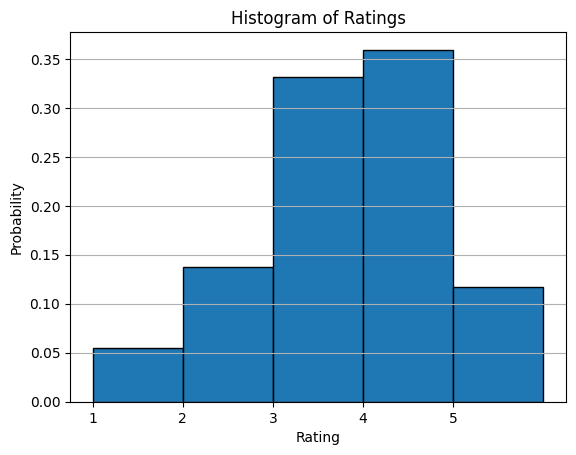

In [15]:
# Create a histogram
plt.hist(ratings['rating'], bins=[1, 2, 3, 4, 5, 6], density=True,edgecolor='black')
plt.xlabel('Rating')            # X axis
plt.ylabel('Probability')       # Y axis
plt.title('Histogram of Ratings')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y')

plt.show()

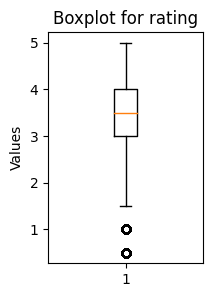

In [16]:
plt.figure(figsize=(2, 3))
plt.boxplot(ratings['rating'])
plt.ylabel('Values')
plt.title('Boxplot for rating')
plt.show()

> Observing the data, it's apparent that around **60%** of the ratings fall within the range of **[3, 5]**. This indicates that the majority of ratings cluster around these values.

> In the box plot analysis, **two potential outliers** are identified with values close to 1. However, we might refrain from classifying them as outliers, considering the possibility that individuals could provide low ratings for specific films. In this scenario, we opt to retain these values for analysis, given that our rating scale spans from 0 to 5.

In [17]:
def top_movies_by_ratings(df, n):
    title_counts = df['title'].value_counts()
    return title_counts.nlargest(n)

In [18]:
# Create good_ratings and bad_ratings DataFrames
good_ratings = ratings[ratings['rating'] > 4.0]
bad_ratings = ratings[ratings['rating'] < 2.0]

# Find the 10 movies with the most good ratings
top_good_movies = top_movies_by_ratings(good_ratings, 10)

# Find the 10 movies with the most bad ratings
top_bad_movies = top_movies_by_ratings(bad_ratings, 10)

print("="*80)
print("Top 10 movies with the most GOOD ratings:")
print("="*80)
print(top_good_movies)
print("="*80)

print("Top 10 movies with the most BAD ratings:")
print("="*80)

print(top_bad_movies)
print("="*80)

Top 10 movies with the most GOOD ratings:
Lord of the Rings: The Fellowship of the Ring, The (2001)    3017
Lord of the Rings: The Return of the King, The (2003)        2792
Lord of the Rings: The Two Towers, The (2002)                2690
Memento (2000)                                               2184
Gladiator (2000)                                             1835
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1801
Eternal Sunshine of the Spotless Mind (2004)                 1711
Spirited Away (Sen to Chihiro no kamikakushi) (2001)         1378
Kill Bill: Vol. 1 (2003)                                     1360
Shrek (2001)                                                 1311
Name: title, dtype: int64
Top 10 movies with the most BAD ratings:
Charlie's Angels (2000)                                      338
Battlefield Earth (2000)                                     317
Scary Movie (2000)                                           296
Star Wars: Episode II - Attack of th

> - The initial list showcases films with exceptionally high ratings, specifically those surpassing the 4.5 mark. Notably, the top-rated films exhibit considerably higher values compared to the rest of the database, particularly highlighting movies like "Lord of the Rings." This discrepancy suggests that these films, exemplified by "Lord of the Rings," enjoy widespread acclaim and are generally well-received by viewers.

> - In contrast, the second list delves into films that have received predominantly low ratings. The stark contrast between the top positions in this list is evident, with values such as 338 (from the second) vs 3017(from the first one). This discrepancy underscores a noteworthy trend – individuals appear more inclined to express their opinions by rating films they enjoy positively, as reflected in the first list. The larger numerical values in the second list signify a collective tendency to rate films more sparingly when disliking them, emphasizing the subjective nature of movie ratings and the likelihood that viewers are more vocal in praising films they appreciate.

## 2.2. Genres distribution

In [19]:
genres = movies['genres'].str.split('|', expand=True).stack()  # slpit the values
unique_genres = genres.unique()
num_unique_genres = len(unique_genres)
for i, genre in enumerate(unique_genres, start=1):
    print(f"{i}. {genre}")

assert num_unique_genres == 20  # to check if they are unique

1. Crime
2. Drama
3. Comedy
4. Adventure
5. Sci-Fi
6. Thriller
7. Romance
8. Horror
9. Mystery
10. Action
11. Animation
12. Children
13. Documentary
14. War
15. Musical
16. Western
17. Fantasy
18. IMAX
19. Film-Noir
20. (no genres listed)


In [20]:
def count_genres(dataset):
    genres = dataset['genres'].str.split('|', expand=True).stack()
    unique_genres = list(set(genres))
    genres_ds = dataset['genres'].str.split('|', expand=True)

    genre_count = {genre: 0 for genre in unique_genres}

    for index, row in genres_ds.iterrows():
        for genre in row:
            if genre in genre_count:
                genre_count[genre] += 1

    genre_count_list = [[genre, count] for genre, count in genre_count.items()]
    genre_count_list.sort(key=lambda x: x[1], reverse=True)
    for genre, count in genre_count_list:
        print([genre, count])
    return genre_count_list

In [21]:
genre_count_list = count_genres(movies)

['Drama', 13666]
['Comedy', 8898]
['Thriller', 5437]
['Documentary', 4473]
['Action', 3901]
['Romance', 3846]
['Horror', 3431]
['Crime', 2425]
['(no genres listed)', 2200]
['Sci-Fi', 1907]
['Adventure', 1906]
['Children', 1639]
['Animation', 1553]
['Mystery', 1516]
['Fantasy', 1456]
['War', 679]
['Musical', 308]
['Western', 194]
['IMAX', 173]
['Film-Noir', 21]


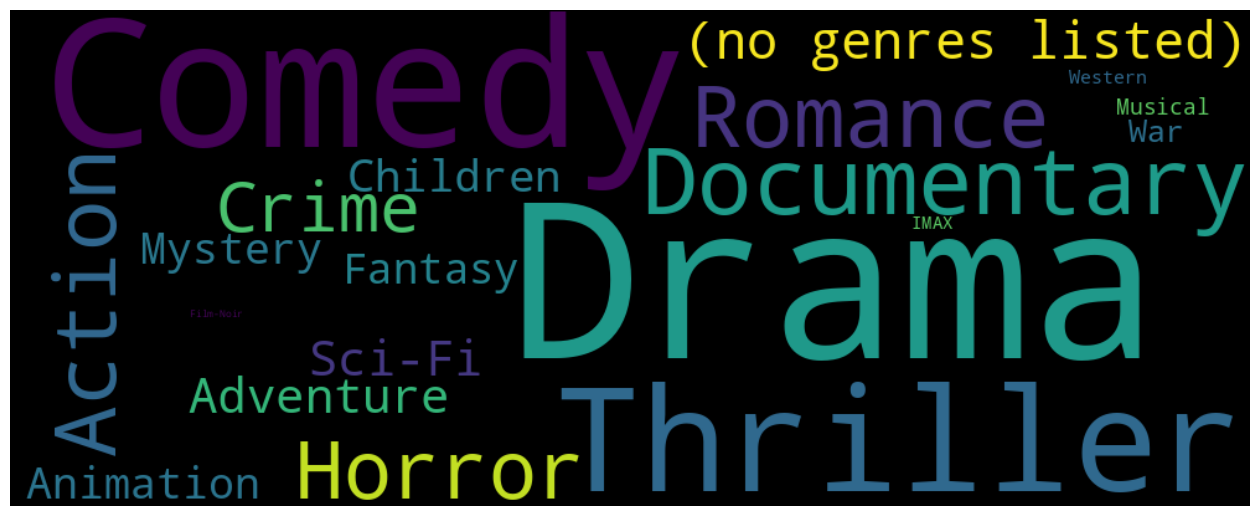

In [22]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(dict(genre_count_list))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [23]:
movies_before = movies[movies['year'] < 2010]
movies_after  =  movies[movies['year'] > 2010]

['Drama', 5824]
['Comedy', 3662]
['Thriller', 2154]
['Romance', 1815]
['Action', 1642]
['Documentary', 1503]
['Horror', 1272]
['Crime', 1127]
['Adventure', 835]
['(no genres listed)', 776]
['Sci-Fi', 713]
['Children', 692]
['Mystery', 648]
['Fantasy', 627]
['Animation', 619]
['War', 323]
['Musical', 209]
['Western', 69]
['IMAX', 54]
['Film-Noir', 15]


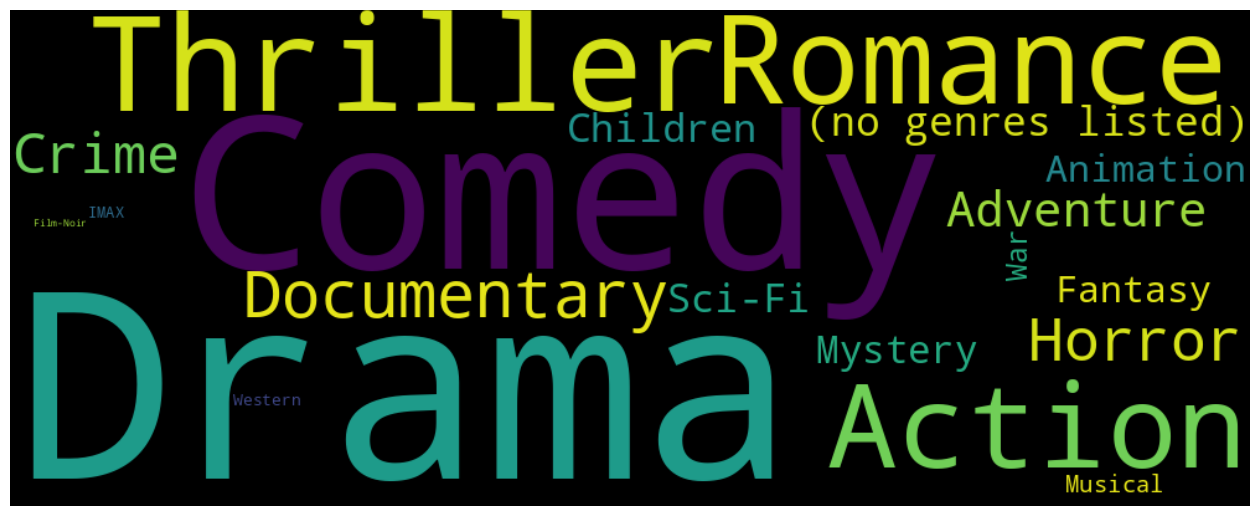

In [24]:
genre_count_list_before = count_genres(movies_before)
genre_wordcloud = WordCloud(width=1000, height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(dict(genre_count_list_before))
# Plotting the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

['Drama', 7123]
['Comedy', 4777]
['Thriller', 3010]
['Documentary', 2722]
['Action', 2047]
['Horror', 1983]
['Romance', 1802]
['(no genres listed)', 1341]
['Crime', 1180]
['Sci-Fi', 1111]
['Adventure', 972]
['Children', 848]
['Animation', 843]
['Mystery', 793]
['Fantasy', 746]
['War', 324]
['Western', 110]
['IMAX', 102]
['Musical', 76]
['Film-Noir', 5]


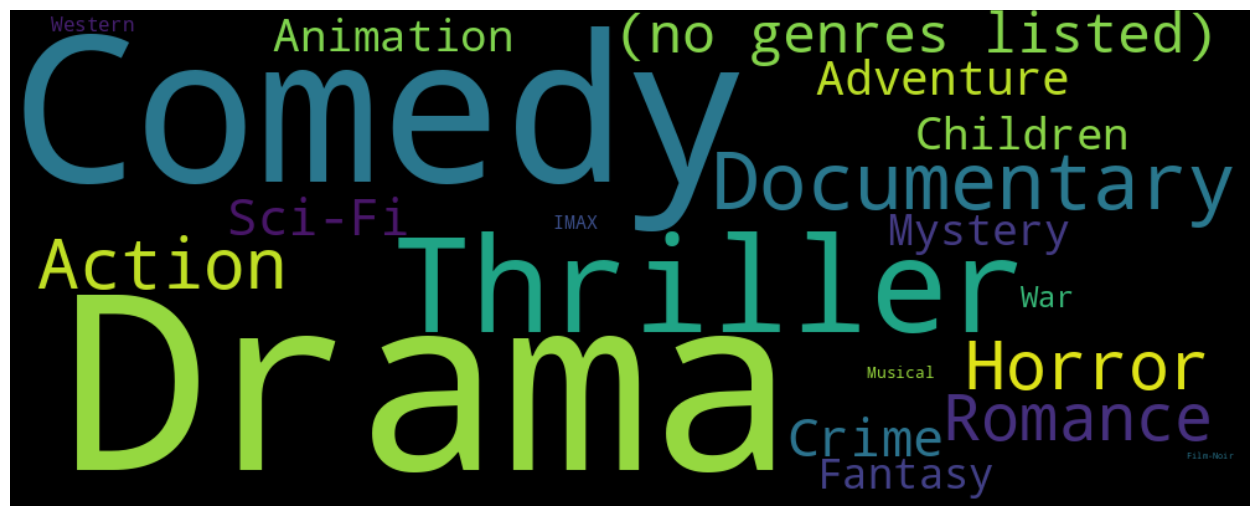

In [25]:
genre_count_list_after= count_genres(movies_after)
genre_wordcloud = WordCloud(width=1000, height=400, background_color='black')
genre_wordcloud.generate_from_frequencies(dict(genre_count_list_after))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Comment:

> We can see that there are values like Action that have changed, specifically we see an increase so that in the second wordcloud we see Action as a word with more 'power' around the others.

> A very peculiar characteristic is that we can see that in the worldcloud before 2010 there are 15 Film-Noir films and after 2010 only 5, this is because this type of film was a film genre that had its heyday in Hollywood during the 1940s and 1950s, so it is normal that its 'fashion' has passed.

> Also all those types of films that require a high level of use of new technologies have increased, so we can see an increase in the vast majority of related categories, such as science fiction, animated films.

> Thanks to the use of these worldclouds we can see the trend of each category without even having the values / statistics, with which we can make some statements simply by looking at these types of schemes.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [26]:
movies['genres_arr'] = movies['genres'].apply(lambda x: x.split('|'))
movies['genres_arr'].fillna('').astype('str')

0                         ['Crime', 'Drama']
1                                 ['Comedy']
2        ['Adventure', 'Sci-Fi', 'Thriller']
3                      ['Comedy', 'Romance']
4                                 ['Comedy']
                        ...                 
33163        ['Action', 'Comedy', 'Romance']
33164                              ['Drama']
33165                        ['Documentary']
33166                    ['Comedy', 'Drama']
33167                 ['(no genres listed)']
Name: genres_arr, Length: 33168, dtype: object

In [27]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [28]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,[(no genres listed)]
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"[Action, Adventure, Fantasy]"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,[(no genres listed)]
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"[Action, Adventure, Sci-Fi]"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"[Action, Adventure, Comedy, Sci-Fi]"


In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(movies_filtered['genres'])
tfidf_matrix.shape

(7890, 130)

## 3.2. Calculate most similar movies

In [30]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [31]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):

    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]

    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))

print_similarity_vector(122904, cosine_sim)

Se han truncado las últimas 5000 líneas del flujo de salida.
0.161 180569 The Star (2017)
0.000 180571 The Mayor (2017)
0.000 180587 The Wife (2017)
0.000 180589 Leaning Into the Wind: Andy Goldsworthy (2017)
0.000 180591 Jane (2017)
0.061 180677 Child of Satan (2016)
0.057 180685 Before the Fall (2016)
0.000 180735 Hello Again (2017)
0.000 180737 A Christmas Prince (2017)
0.000 180763 LoveTrue (2016)
0.064 180793 Evil Bong: High 5 (2016)
0.000 180825 Pecking Order (2017)
0.419 180833 The Humanity Bureau (2017)
0.000 180835 The Lost Wife of Robert Durst (2017)
0.000 180837 Tokyo Project (2017)
0.000 180841 Interlude In Prague (2017)
0.161 180843 Schreckenstein Castle (2016)
0.000 180859 Bruce Springsteen: In His Own Words (2016)
0.000 180861 Ceasefire (2017)
0.000 180919 Starfish (2016)
0.178 180953 The Carer (2016)
0.000 180957 Eric Clapton: Life in 12 Bars (2017)
0.178 180959 The Bribe of Heaven (2016)
0.052 180965 The Healer (2017)
0.000 180973 Memoria (2016)
0.119 180975 Agadah (20

In [32]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]

    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])
    enumerated_similarities = list(enumerate(sim_scores))

    sorted_similarities = sorted(enumerated_similarities, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[0:num_movies]

    recommendations = []
    for (index_target, similarity) in top_similarities:

        # Replace this comment with code to obtain movie_id, title, genres

        movie_id = movies.iloc[index_target].movie_id
        title = movies.iloc[index_target].title
        genres = movies.iloc[index_target].genres


        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

In [33]:
# Pirates of the Caribbean - Filtered
genre_content_based_recommendations(122896, movies_filtered,cosine_sim,10) # per les > 2015

,similarity,movie_id,title,genres
0,1.0,122888,Ben-hur (2016),(no genres listed)
1,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
2,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
3,1.0,138212,Spectral (2016),(no genres listed)
4,1.0,141131,Guardians (2016),(no genres listed)
5,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
6,1.0,150724,Army Dog (2016),(no genres listed)
7,1.0,151461,Fitoor (2016),(no genres listed)
8,1.0,151593,Martyrs (2016),(no genres listed)
9,1.0,152037,Grease Live (2016),(no genres listed)


In [34]:
# Midsommer - Filtered
genre_content_based_recommendations(201646, movies_filtered,cosine_sim,10)

,similarity,movie_id,title,genres
0,1.0,155064,The Neon Demon (2016),Drama|Horror|Mystery
1,1.0,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
2,1.0,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
3,1.0,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
4,1.0,184067,Without Name (2017),Drama|Horror|Mystery
5,1.0,190755,The Little Stranger (2018),Drama|Horror|Mystery
6,1.0,192291,Rift (2017),Drama|Horror|Mystery
7,1.0,201646,Midsommar (2019),Drama|Horror|Mystery
8,1.0,201739,Wounds (2019),Drama|Horror|Mystery
9,1.0,202225,Something (2018),Drama|Horror|Mystery


In [35]:
def calculate_precision(recommended_movies, relevant_movies):
    relevant_count = sum(1 for movie in recommended_movies if movie in relevant_movies)
    total_count = len(recommended_movies)
    if total_count == 0:
        return 0
    precision = relevant_count / total_count
    return precision

**Obs:** Having chosen movies from 2019, it makes more sense to make comparisons with the variable of movies filtered by year, so the recommendation will be more adjusted to the year of release of the mentioned movie.

In [36]:
#Lo nunca visto (2019)
recommendations_movie1 = genre_content_based_recommendations(208689, movies_filtered,cosine_sim,10)
recommendations_movie1.head(10)

,similarity,movie_id,title,genres
0,1.0,143859,"Hail, Caesar! (2016)",Comedy
1,1.0,148888,Zoolander 2 (2016),Comedy
2,1.0,150194,Quo vado? (2016),Comedy
3,1.0,151311,Wiener-Dog (2016),Comedy
4,1.0,151455,Eddie the Eagle (2016),Comedy
5,1.0,151739,Dirty Grandpa (2016),Comedy
6,1.0,152069,Busco Novio Para Mi Mujer (2016),Comedy
7,1.0,152091,The Brothers Grimsby (2016),Comedy
8,1.0,152248,Rosalie Blum (2016),Comedy
9,1.0,152862,L'abbiamo fatta grossa (2016),Comedy


- Relevant coherence recommendation :
  - Busco Novio Para Mi Mujer (2016)
  - Zoolander 2 (2016)
  - Busco Novio Para Mi Mujer (2016)
  - Quo vado? (2016)
  - The Brothers Grimsby (2016)
  - Eddie the Eagle (2016)
  - Wiener-Dog (2016)

- Irrelevant:
  - Hail, Caesar! (2016)
  - L'abbiamo fatta grossa (2016)
  - Rosalie Blum (2016)
  - Dirty Grandpa (2016)

In [37]:
relevant_1 = [152069, 148888, 150194, 151455,152091, 151311	]
precision_movie1 = calculate_precision(recommendations_movie1['movie_id'], relevant_1)
print(f'Precision for Movie 1: {precision_movie1 * 100:.2f}%')

Precision for Movie 1: 60.00%


In [38]:
#Parasite (2019)
recommendations_movie2 = genre_content_based_recommendations(202439, movies_filtered,cosine_sim,10)
recommendations_movie2.head(10)

,similarity,movie_id,title,genres
0,1.0,151319,Notias (2016),Comedy|Drama
1,1.0,152547,Love Records (2016),Comedy|Drama
2,1.0,155659,Florence Foster Jenkins (2016),Comedy|Drama
3,1.0,157268,Don't Think Twice (2016),Comedy|Drama
4,1.0,157318,Perfect Strangers (2016),Comedy|Drama
5,1.0,157385,Geezer (2016),Comedy|Drama
6,1.0,159077,The Meddler (2016),Comedy|Drama
7,1.0,159163,The Other Side of the Wind (2016),Comedy|Drama
8,1.0,160201,La pazza gioia (2016),Comedy|Drama
9,1.0,160533,Adult Life Skills (2016),Comedy|Drama


- Relevant coherence recommendation :
  - Adult Life Skills (2016)
  - Don't Think Twice (2016)
  - Love Records (2016)
  - Notias (2016)
  - Perfect Strangers (2016)
  - The Other Side of the Wind (2016)

- Irrelevant:
  - Florence Foster Jenkins (2016)
  - Geezer (2016)
  - La pazza gioia (2016)
  - The Meddler (2016)

In [39]:
relevant_2 = [151319, 152547, 157268, 157318, 159163, 160533]
precision_movie2 = calculate_precision(recommendations_movie2['movie_id'], relevant_2)
print(f'Precision for Movie 1: {precision_movie2 * 100:.2f}%')

Precision for Movie 1: 60.00%


In [40]:
# 204698 Joker (2019)
recommendations_movie3 = genre_content_based_recommendations(204698, movies_filtered,cosine_sim,10)
recommendations_movie3.head(10)


,similarity,movie_id,title,genres
0,1.0,160301,Udta Punjab (2016),Crime|Drama|Thriller
1,1.0,161652,Trivisa (2016),Crime|Drama|Thriller
2,1.0,161680,American Hostage (2016),Crime|Drama|Thriller
3,1.0,162606,The Accountant (2016),Crime|Drama|Thriller
4,1.0,162828,Imperium (2016),Crime|Drama|Thriller
5,1.0,164939,Vincent N Roxxy (2016),Crime|Drama|Thriller
6,1.0,165227,Adulterers (2016),Crime|Drama|Thriller
7,1.0,165543,Manson's Lost Girls (2016),Crime|Drama|Thriller
8,1.0,166020,Dog Eat Dog (2016),Crime|Drama|Thriller
9,1.0,166755,Hacker (2016),Crime|Drama|Thriller


- Relevant coherence recommendation :
  - Udta Punjab (2016)
  - Trivisa (2016)
  - American Hostage (2016)
  - The Accountant (2016)
  - Imperium (2016)
  - Vincent N Roxxy (2016)
  - Hacker (2016)

- Irrelevant:
  - Adulterers (2016)
  - Manson's Lost Girls (2016)
  - Dog Eat Dog (2016)

In [41]:
relevant_3 = [160301, 161652, 161680, 162606, 162828, 164939, 166755]
precision_movie3 = calculate_precision(recommendations_movie3['movie_id'], relevant_3)
print(f'Precision for Movie 1: {precision_movie3 * 100:.2f}%')

Precision for Movie 1: 70.00%


In [42]:
avg_precision_movie = (precision_movie1 + precision_movie2 + precision_movie3) / 3
print('Average precision across the three lists:'  ,round(avg_precision_movie,3), '%')

Average precision across the three lists: 0.633 %


To improve the content-based recommendation system:
<ol>
  <li><strong>Apply TF-IDF vectorization to genres.</strong></li>
  <li><strong>Combine multiple features like genres, cast, and director.</strong></li>
  <li><strong>Implement feature weighting based on importance.</strong></li>
  <li><strong>Normalize numerical features for fair influence.</strong></li>
  <li><strong>Consider a hybrid system with collaborative filtering.</strong></li>
  <li><strong>Experiment with different similarity measures (e.g., Pearson, Jaccard).</strong></li>
  <li><strong>Dynamically adjust feature importance based on feedback.</strong></li>
  <li><strong>Include user-specific information and preferences.</strong></li>
  <li><strong>Fine-tune the number of recommendations for optimal balance.</strong></li>
  <li><strong>Regularly evaluate and iterate the model for continuous improvement.</strong></li>
</ol>




### EXTRA

In [44]:
tags_df = pd.read_csv(FILENAME_TAGS,
                    sep=',',
                    engine='python',
                    encoding='latin-1',
                    names=['user_id','movie_id','tag','timestamp'])
movies = pd.read_csv(FILENAME_MOVIES,
                    sep=',',
                    engine='python',
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
movies['year'] = movies.apply(lambda x: yearof(x['title']), axis=1)

# Aggressively filter tags based on document frequency
min_df = 10  # Minimum document frequency
tags_df = tags_df.groupby('movie_id').filter(lambda x: len(x) >= min_df)

tags_df.head(5)

,user_id,movie_id,tag,timestamp
0,4,44665,unreliable narrators,1573943619
1,68,3481,music,1472113217
2,91,3481,based on a book,1399117141
3,91,3481,break-up,1399117159
4,91,3481,Catherine Zeta-Jones,1399117136


In [45]:
# Combine tags with existing movie genres
combined_data = tags_df.merge(movies, on='movie_id', how='inner')

#FIltering only films between 2003,2006
combined_data_filtered = combined_data[combined_data['year'] == 2003]
combined_data_filtered = combined_data_filtered.reset_index()

combined_data_filtered['genres'] = combined_data_filtered['genres'].str.replace('|', ' ')
combined_data_filtered['tag'] = combined_data_filtered['tag'].fillna('')  # Fill missing tags with an empty string
combined_data_filtered.head(5)

<ipython-input-45-3902de46a244>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_data_filtered['genres'] = combined_data_filtered['genres'].str.replace('|', ' ')


,index,user_id,movie_id,tag,timestamp,title,genres,year
0,12298,294,7142,dance,1541112897,Honey (2003),Drama Romance,2003
1,12299,294,7142,feel-good,1541112875,Honey (2003),Drama Romance,2003
2,12300,294,7142,motivational,1541112889,Honey (2003),Drama Romance,2003
3,12301,294,7142,music,1541112954,Honey (2003),Drama Romance,2003
4,12302,6550,7142,blackmail,1528595851,Honey (2003),Drama Romance,2003


In [46]:
# Create a TF-IDF vectorizer for the combined data
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Compute TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data_filtered['genres'] + ' ' + combined_data_filtered['tag'])
tfidf_matrix.shape
# Calculate similarity scores using the combined TF-IDF vectors
similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [49]:
def content_based_recommendations(movie_id, combined_data_filtered, num_movies=10):
    index_source = combined_data_filtered[combined_data_filtered['movie_id'] == movie_id].index[0]
    sim_scores = list(enumerate(similarities[index_source]))
    sorted_similarities = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    top_similarities = [item for item in sorted_similarities if item[0] != index_source]

    # Keep track of recommended movies to avoid duplicates with different tags
    recommended_movies = set()
    recommendations = []

    for index_target, similarity in top_similarities:
        target_movie_id = combined_data_filtered.iloc[index_target]['movie_id']
        target_movie_title = combined_data_filtered.iloc[index_target]['title']

        # Check if the movie with the same title is already recommended
        if target_movie_title not in recommended_movies:
            recommended_movies.add(target_movie_title)

            recommended_movie_tag = combined_data_filtered.iloc[index_target]['tag']

            recommendations.append({
                'movie_id': target_movie_id,
                'title': target_movie_title,
                'tag': recommended_movie_tag,
                'similarity': similarity,
            })

        # Stop when reaching the desired number of recommendations
        if len(recommendations) == num_movies:
            break

    return pd.DataFrame(recommendations)


In [50]:
movie_id = 38086
recommendations = content_based_recommendations(movie_id,combined_data_filtered, num_movies=10)
recommendations.head(10)

,movie_id,title,tag,similarity
0,38086,Wishing Stairs (Yeogo goedam 3: Yeowoo gyedan)...,ballet,1.000000
1,7385,Twentynine Palms (2003),3.5,0.437031
2,6250,Dreamcatcher (2003),disturbing,0.177722
3,6220,Willard (2003),rats,0.170748
4,30745,Gozu (GokudÃ´ kyÃ´fu dai-gekijÃ´: Gozu) (2003),surreal,0.160260
5,27658,Love Object (2003),sex,0.157071
6,27781,Svidd Neger (2003),surreal,0.135542
7,7299,Monsieur Ibrahim (Monsieur Ibrahim et les fleu...,R,0.125417
8,34155,Saraband (2003),R,0.125417
9,6615,Freddy vs. Jason (2003),horror,0.120471


Exploring the output we can say:

> The recommendations exhibit a diversity of movie genres and tags, indicating that the content-based recommendation system is capturing various aspects of movie content.

**Normalization of Similarity Scores:**

> The similarity scores are normalized, ranging from 0 to 1. A score of 1 indicates the movie's perfect similarity with itself, while lower scores suggest decreasing similarity with the input movie.

**Content-Based Approach:**

> The recommendations are generated based on a combination of movie genres and tags, reflecting a content-based approach. This allows the system to suggest movies with similar thematic elements.

**Handling Duplicates:**

> The issue of the input movie appearing in the recommendations has been addressed. Recommendations now exclude the input movie itself and filter out duplicates with the same title but different tags, providing a cleaner and more meaningful output.

**User-Generated Tags:**

> The presence of tags like '3.5' may indicate user-generated content that might need further validation or cleaning. Ensuring the quality of user-generated tags is crucial for the effectiveness of the recommendation system.

<font size="+1" color="#003300">We hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>